In [0]:
import pandas as pd
import numpy as np
from ftplib import FTP
from calendar import isleap
import matplotlib.pyplot as plt
import copy

In [0]:
#READ ME for .dly files: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
wids = [11,4,2,4]+[5,1,1,1]*31
nam = ['VAL','MFL','QFL','SFL']*31
num = list(range(1,32))*4
num.sort()
val_flg = [nam[i]+str(num[i]) for i in range(len(num))]

#weather station in Aledo County, IL
stat = pd.read_fwf('USC00110072.dly',widths=wids,header=None,index_col=False,names=['ID','YR','MO','VAR']+val_flg)

In [0]:
def var_ext(var,stat):
  sv = pd.Series()
  
  # index of variable to extract
  idx = stat[stat.loc[:,'VAR']==var].index.tolist()
  
  # days in each month incl. leap year day
  days = [31,28,31,30,31,30,31,31,30,31,30,31]
  ldays = [31,29,31,30,31,30,31,31,30,31,30,31]
  
  # convenience variables for years and months
  yr = stat.loc[idx,'YR']
  mo = stat.loc[idx,'MO']
  
  # loop through every instance of the variable to extract
  for i in idx:
    # number of days in month
    if isleap(yr[i]):
      d = ldays[mo[i]-1]
    else:
      d = days[mo[i]-1]
    # only pull values that correspond to days in the month
    out = stat.loc[i][list(range(4,4*(d+1),4))] 
    
    # replace missing values with NaN
    out[out==-9999] = np.nan
    
    # reindex with proper time stamp
    tm = pd.to_datetime({'year':yr[i],'month':mo[i],'day':range(1,d+1)})
    out = pd.Series(out.values,index=tm)*0.1 # convert to measured units
    sv = pd.concat([sv,out])
    
  # get full date vector and expand NaNs for missing data
  date1 = pd.to_datetime({'year':yr[idx[0]],'month':mo[idx[0]],'day':[1]})
  date2 = pd.to_datetime({'year':yr[idx[-1]],'month':mo[idx[-1]],'day':[d]})
  all_dates = pd.date_range(start=date1[0],end=date2[0])
  sv = sv.reindex(index=all_dates)
  return sv

In [0]:
#extract TMAX
tmax = var_ext('TMAX', stat)
tmax.head()

1901-01-01   -6.1
1901-01-02   -2.8
1901-01-03    1.1
1901-01-04      5
1901-01-05    0.6
Freq: D, dtype: object

In [0]:
#extract TMIN
tmin = var_ext('TMIN', stat)
tmin.head()

1901-01-01     -20
1901-01-02   -16.1
1901-01-03   -14.4
1901-01-04    -2.8
1901-01-05      -5
Freq: D, dtype: object

In [0]:
#combine TMAX and TMIN
temp = pd.concat([tmax, tmin], axis=1)
temp.rename(columns = {0:'TMAX_obs', 1:'TMIN_obs'}, inplace = True)

temp.to_csv('tmax_tmin.csv', header = True, index = True)

In [0]:
#make copies of observed max and min temp that we can edit while keeping original intact

temp['TMAX_bound'] = temp['TMAX_obs']
temp['TMIN_bound'] = temp['TMIN_obs']

temp.head(3)

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound
1901-01-01,-6.1,-20,-6.1,-20
1901-01-02,-2.8,-16.1,-2.8,-16.1
1901-01-03,1.1,-14.4,1.1,-14.4


In [0]:
#want to find all observed TMAX above 29 and replace them with 29
temp.loc[temp.TMAX_bound >= 29, 'TMAX_bound'] = 29

In [0]:
#want to find all observed TMAX below 9 and replace them with 9
temp.loc[temp.TMAX_bound <= 9, 'TMAX_bound'] = 9

In [0]:
#want to find all observed TMIN above 29 and replace them with 29
temp.loc[temp.TMIN_bound >= 29, 'TMIN_bound'] = 29

In [0]:
#want to find all observed TMIN below 9 and replace them with 9
temp.loc[temp.TMIN_bound <= 9, 'TMIN_bound'] = 9

In [0]:
#inspect a random middle section of the data
temp.iloc[475:525]

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound
1902-04-21,31.1,12.8,29,12.8
1902-04-22,26.1,11.7,26.1,11.7
1902-04-23,15,0.6,15,9
1902-04-24,23.3,-0.6,23.3,9
1902-04-25,22.8,10,22.8,10
1902-04-26,22.2,3.9,22.2,9
1902-04-27,18.3,2.8,18.3,9
1902-04-28,23.3,-0.6,23.3,9
1902-04-29,21.7,11.1,21.7,11.1
1902-04-30,22.2,7.8,22.2,9


In [0]:
#calculate GDD and add as a column
temp['GDD'] = ((temp['TMAX_bound'] + temp['TMIN_bound'])/2)-9

In [0]:
temp.head()

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound,GDD
1901-01-01,-6.1,-20,9,9,0
1901-01-02,-2.8,-16.1,9,9,0
1901-01-03,1.1,-14.4,9,9,0
1901-01-04,5,-2.8,9,9,0
1901-01-05,0.6,-5,9,9,0


In [0]:
#sanity check to see that not all the GDD values are 0

zeroGDD = temp['GDD'] == 0
nonzeroGDD = temp['GDD'] != 'UCLA Bruins'

sum(zeroGDD)/sum(nonzeroGDD)

0.31794800500486586

In [0]:
#calculate KDD. np.where(condition, value if True, value if False).
temp['KDD'] = np.where(temp['TMAX_obs'] > 29, temp['TMAX_obs'] - 29, 0)

In [0]:
#inspect middle section of data
temp.iloc[475:525]

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound,GDD,KDD
1902-04-21,31.1,12.8,29,12.8,11.9,2.1
1902-04-22,26.1,11.7,26.1,11.7,9.9,0
1902-04-23,15,0.6,15,9,3,0
1902-04-24,23.3,-0.6,23.3,9,7.15,0
1902-04-25,22.8,10,22.8,10,7.4,0
1902-04-26,22.2,3.9,22.2,9,6.6,0
1902-04-27,18.3,2.8,18.3,9,4.65,0
1902-04-28,23.3,-0.6,23.3,9,7.15,0
1902-04-29,21.7,11.1,21.7,11.1,7.4,0
1902-04-30,22.2,7.8,22.2,9,6.6,0


In [0]:
#locate the missing data. we see 960 rows are missing one or more data points.
missingdata = temp[temp.isnull().any(axis=1)]
len(missingdata.index)

960

In [0]:
#remove some missing data by narrowing down to study years
temp = temp.loc['1981-01-01':'2017-12-31']
missingdata = temp[temp.isnull().any(axis=1)]
len(missingdata.index)

506

In [0]:
#what percentage of our data is missing?
len(missingdata.index)/len(temp.index)

0.037442652064525676

In [0]:
#missing data ranges from single points to entire weeks or multiple weeks of missing data
missingdata['2017']

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound,GDD,KDD
2017-01-05,NaN,-13.9,NaN,9,NaN,0
2017-01-06,NaN,-22.8,NaN,9,NaN,0
2017-01-13,NaN,-9.4,NaN,9,NaN,0
2017-02-03,NaN,-9.4,NaN,9,NaN,0
2017-02-11,9.4,NaN,9.4,NaN,NaN,0
2017-03-14,NaN,-7.2,NaN,9,NaN,0
2017-03-24,10,NaN,10,NaN,NaN,0
2017-03-25,24.4,NaN,24.4,NaN,NaN,0
2017-06-04,32.8,NaN,29,NaN,NaN,3.8
2017-12-13,NaN,-8.3,NaN,9,NaN,0


In [0]:
temp.to_csv('temp_data.csv', header = True, index = True)

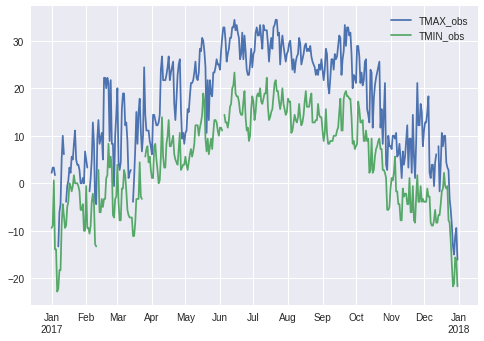

In [0]:
#Need to make some rules about interpolating temperature data. Use a complete portion of data to test.

#disable copy of slice warning
pd.options.mode.chained_assignment = None  # default='warn'

temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = temp.loc['2017-01-01':'2017-12-31']

temp_sample.plot()

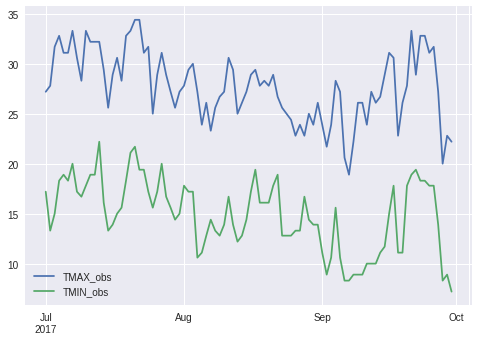

In [0]:
#focus in on smaller complete sample
temp_sample = temp.loc['2017-07-01':'2017-09-30']
temp_sample.plot()

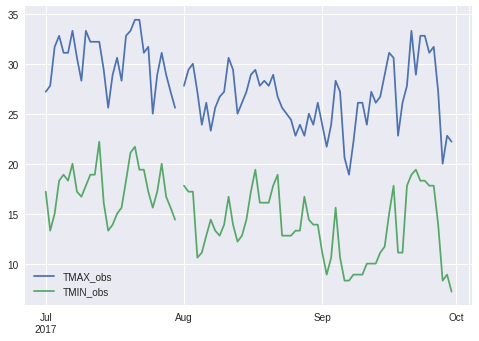

In [0]:
#There are 91 days between Jul 1st and Oct 31st. Pick random day to remove.

temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = temp.loc['2017-07-01':'2017-09-30']

import random
for x in range(1):
  random_day = random.randint(1,92)

temp_sample.iloc[random_day] = np.nan
temp_sample.iloc[random_day]

temp_sample.plot()



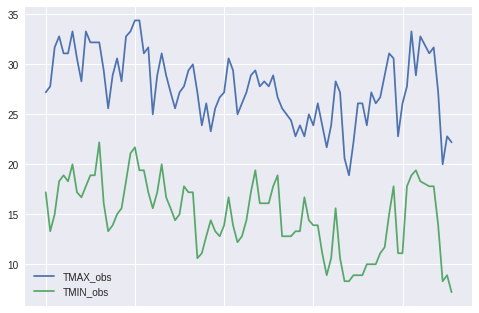

In [0]:
temp_sample.interpolate().plot()

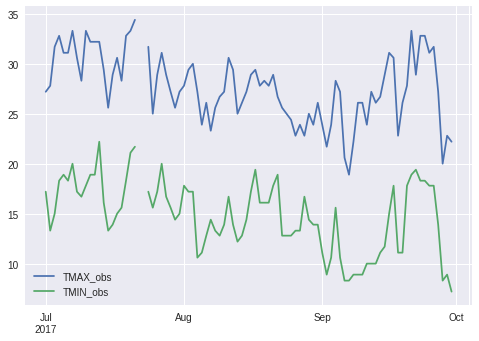

In [0]:
#Remove one point and its nearest neighbors (3 missing points in a row)

temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = temp.loc['2017-07-01':'2017-09-30']

import random
for x in range(1):
  random_day = random.randint(1,92)

temp_sample.iloc[random_day - 1:random_day + 1] = np.nan


temp_sample.plot()

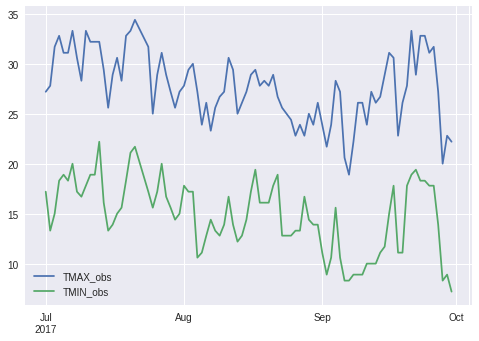

In [0]:
temp_sample.interpolate().plot()

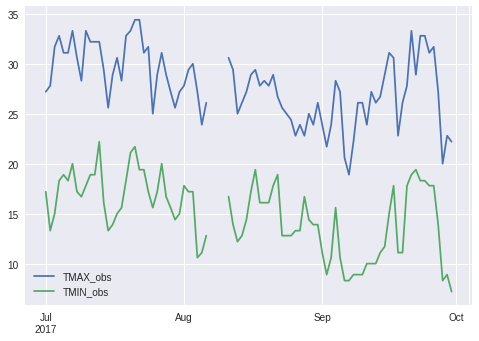

In [0]:
#Remove 4 points in a row

temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = temp.loc['2017-07-01':'2017-09-30']

import random
for x in range(1):
  random_day = random.randint(1,92)

temp_sample.iloc[random_day:random_day + 4] = np.nan


temp_sample.plot()

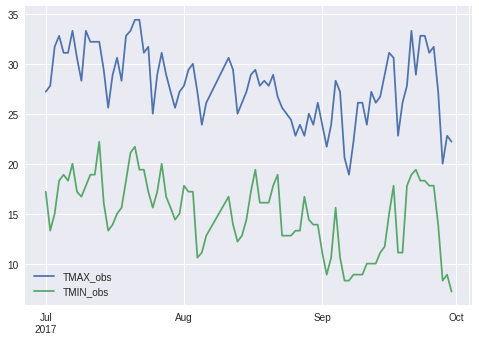

In [0]:
temp_sample.interpolate().plot()
temp_sample_interpolated = temp_sample.interpolate()

In [0]:
temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
temp.index = pd.to_datetime(temp.index)


missing = temp_sample.iloc[random_day-5:random_day+5]
interpolated = temp_sample_interpolated.iloc[random_day-5:random_day+5]
original = temp.loc[temp_sample.iloc[random_day-5:random_day+5].index]

aggregate = pd.concat([missing, interpolated, original], axis = 1)

aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']

aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']

aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']

aggregate = aggregate[['TMAX_obs','TMAX_inter','TMAX_original','TMAX_difference','TMIN_obs','TMIN_inter','TMIN_original','TMIN_difference']]

aggregate

NameError: ignored

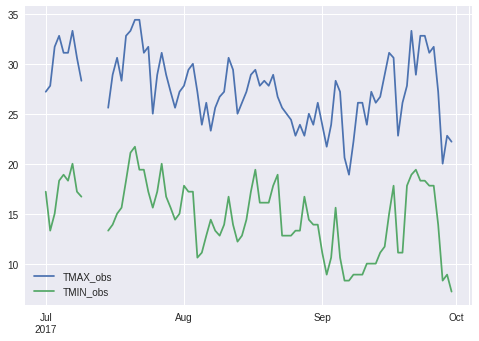

In [0]:
#Remove 5 points in a row
import copy

temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = copy.deepcopy(temp.loc['2017-07-01':'2017-09-30']) #added deepcopy

import random
for x in range(1):
  random_day = random.randint(1,92)

temp_sample.iloc[random_day:random_day + 5] = np.nan


temp_sample.plot()

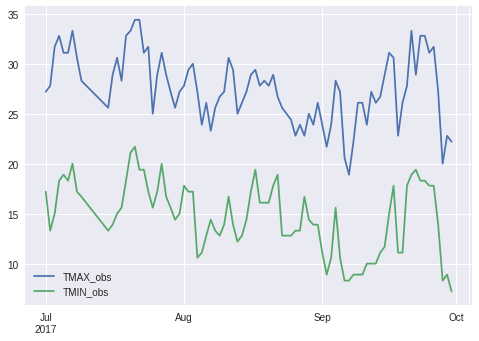

In [0]:
temp_sample.interpolate().plot()
temp_sample_interpolated = temp_sample.interpolate()

In [0]:
#removed these b/c learned (the hard way) about deep copies
#temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
#temp.index = pd.to_datetime(temp.index)

missing = temp_sample.iloc[random_day-5:random_day+5]
interpolated = temp_sample_interpolated.iloc[random_day-5:random_day+5]
original = temp.loc[temp_sample.iloc[random_day-5:random_day+5].index]

aggregate = pd.concat([missing, interpolated, original], axis = 1)

aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']

aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']

aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']

aggregate = aggregate[['TMAX_obs','TMAX_inter','TMAX_original','TMAX_difference','TMIN_obs','TMIN_inter','TMIN_original','TMIN_difference']]

aggregate

,TMAX_obs,TMAX_inter,TMAX_original,TMAX_difference,TMIN_obs,TMIN_inter,TMIN_original,TMIN_difference
2017-07-05,31.1,31.10,31.1,0.00,18.9,18.900000,18.9,0.000000
2017-07-06,31.1,31.10,31.1,0.00,18.3,18.300000,18.3,0.000000
2017-07-07,33.3,33.30,33.3,0.00,20.0,20.000000,20.0,0.000000
2017-07-08,30.6,30.60,30.6,0.00,17.2,17.200000,17.2,0.000000
2017-07-09,28.3,28.30,28.3,0.00,16.7,16.700000,16.7,0.000000
2017-07-10,NaN,27.85,33.3,-5.45,NaN,16.133333,17.8,-1.666667
2017-07-11,NaN,27.40,32.2,-4.80,NaN,15.566667,18.9,-3.333333
2017-07-12,NaN,26.95,32.2,-5.25,NaN,15.000000,18.9,-3.900000
2017-07-13,NaN,26.50,32.2,-5.70,NaN,14.433333,22.2,-7.766667
2017-07-14,NaN,26.05,29.4,-3.35,NaN,13.866667,16.1,-2.233333


In [0]:
#Function that finds differences between observed temperatures and interpolated temperatures.
#Remove 5 points in a row
#Plot the differences in a histogram to get a sense of the distribution

#import necessary packages
import pandas as pd
import numpy as np
import copy 
import random

#empty lists to collect differences
TMIN_difs_total = []
TMAX_difs_total = []

#collect random days to see what was selected
random_days = []

#set number of interations with range
for i in range(1000):
  
  #read in observed TMIN and TMAX data. Sample only 2017.
  temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
  temp.index = pd.to_datetime(temp.index)
  temp_sample = copy.deepcopy(temp.loc['2017-07-01':'2017-09-30'])
  
  #generate random days. Set to 87 because selecting 5 days and don't want overflow. No 92nd day in range.
  for x in range(1):
    random_day = random.randint(1,87)
  
  random_days.append(random_day)
  
  #set 5 days in a row to nan to simulate missing data
  temp_sample.iloc[random_day:random_day + 5] = np.nan

  #linearly interpolate between missing days
  temp_sample_interpolated = temp_sample.interpolate()

  missing = temp_sample.iloc[random_day:random_day+5]
  interpolated = temp_sample_interpolated.iloc[random_day:random_day+5]
  original = temp.loc[temp_sample.iloc[random_day:random_day+5].index]
  
  #difference defined as interpolated - original. Negative means underpredicted. Positive means overpredicted.
  aggregate = pd.concat([missing, interpolated, original], axis = 1)
  aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']
  aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']
  aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']
  
  TMAX_difs_list = aggregate.TMAX_difference.tolist()
  
  TMIN_difs_list = aggregate.TMIN_difference.tolist()
  
  TMAX_difs_total.append(TMAX_difs_list)
  TMIN_difs_total.append(TMIN_difs_list)
  
  if (i % 100) == 0:
    print('in progress...')

#result is a list of lists. convert to array to flatten and then back to list for plotting.
TMAX_difs = np.asarray(TMAX_difs_total)
TMAX_difs = TMAX_difs.flatten()
TMAX_difs = TMAX_difs.tolist()

TMIN_difs = np.asarray(TMIN_difs_total)
TMIN_difs = TMIN_difs.flatten()
TMIN_difs = TMIN_difs.tolist()



in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...


In [0]:
len(TMIN_difs)

5000

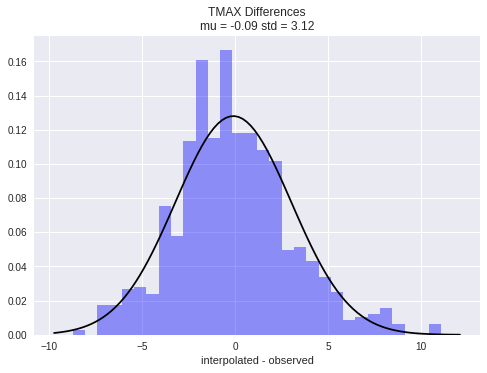

In [0]:
#TMAX difs plot
from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMAX_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMAX_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMAX Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))
plt.show()

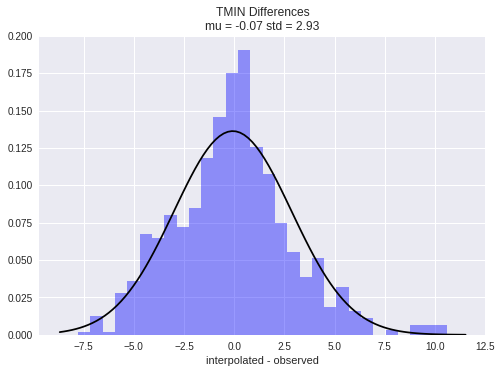

In [0]:
#TMIN difs plot

from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMIN_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMIN_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMIN Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))
plt.show()

In [0]:
#Function that finds differences between observed temperatures and interpolated temperatures.
#Remove 28 DAYS OF DATA (should be a disaster!)
#Plot the differences in a histogram to get a sense of the distribution

#import necessary packages
import pandas as pd
import numpy as np
import copy 
import random

#empty lists to collect differences
TMIN_difs_total = []
TMAX_difs_total = []

#collect random days to see what was selected
random_days = []

#set number of interations with range
for i in range(1000):
  
  #read in observed TMIN and TMAX data. Sample only 2017.
  temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
  temp.index = pd.to_datetime(temp.index)
  temp_sample = copy.deepcopy(temp.loc['2017-07-01':'2017-09-30'])
  
  #generate random days. Set to 64 because selecting 28 days and don't want overflow. No 92nd day in range.
  for x in range(1):
    random_day = random.randint(1,64)
  
  random_days.append(random_day)
  
  #set 28 days in a row to nan to simulate missing data
  temp_sample.iloc[random_day:random_day + 28] = np.nan

  #linearly interpolate between missing days
  temp_sample_interpolated = temp_sample.interpolate()

  missing = temp_sample.iloc[random_day:random_day+28]
  interpolated = temp_sample_interpolated.iloc[random_day:random_day+28]
  original = temp.loc[temp_sample.iloc[random_day:random_day+28].index]
  
  #difference defined as interpolated - original. Negative means underpredicted. Positive means overpredicted.
  aggregate = pd.concat([missing, interpolated, original], axis = 1)
  aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']
  aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']
  aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']
  
  TMAX_difs_list = aggregate.TMAX_difference.tolist()
  
  TMIN_difs_list = aggregate.TMIN_difference.tolist()
  
  TMAX_difs_total.append(TMAX_difs_list)
  TMIN_difs_total.append(TMIN_difs_list)
  
  if (i % 100) == 0:
    print('in progress...')

#result is a list of lists. convert to array to flatten and then back to list for plotting.
TMAX_difs = np.asarray(TMAX_difs_total)
TMAX_difs = TMAX_difs.flatten()
TMAX_difs = TMAX_difs.tolist()

TMIN_difs = np.asarray(TMIN_difs_total)
TMIN_difs = TMIN_difs.flatten()
TMIN_difs = TMIN_difs.tolist()

in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...


In [0]:
len(TMAX_difs)

28000

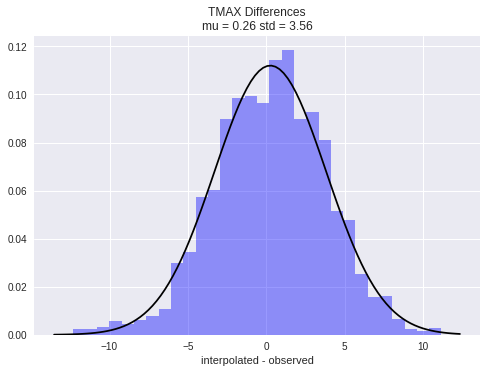

In [0]:
#TMAX difs plot
from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMAX_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMAX_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMAX Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))
plt.show()

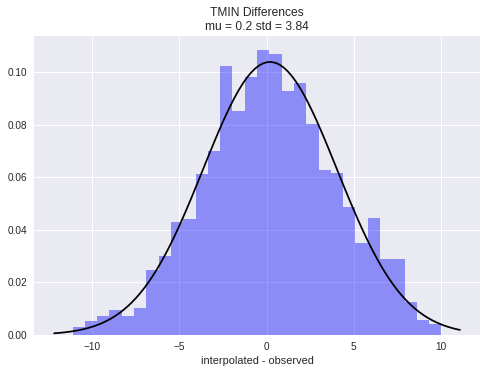

In [0]:
#TMIN difs plot
from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMIN_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMIN_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMIN Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))
plt.show()

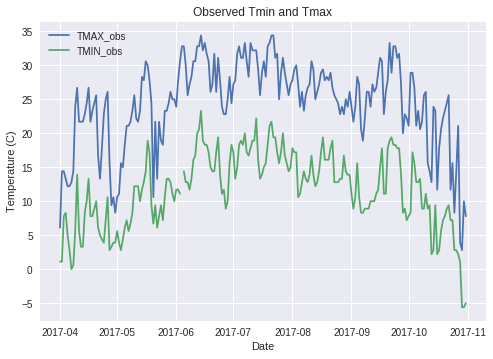

In [0]:
#extend sample range to encompass seasonal variability
temp_sample = copy.deepcopy(temp.loc['2017-04-01':'2017-10-31'])

x = temp_sample.index
y1 = temp_sample.TMAX_obs
y2 = temp_sample.TMIN_obs

plt.plot(x,y1)
plt.plot(x,y2)

plt.title('Observed Tmin and Tmax')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [0]:
#change sample year so it encompasses larger portions of 2017 (April to October)

#Function that finds differences between observed temperatures and interpolated temperatures.
#Remove 5 DAYS OF DATA 
#Plot the differences in a histogram to get a sense of the distribution

#import necessary packages
import pandas as pd
import numpy as np
import copy 
import random

#empty lists to collect differences
TMIN_difs_total = []
TMAX_difs_total = []

#collect random days to see what was selected
random_days = []

#set number of interations with range
for i in range(1000):
  
  #read in observed TMIN and TMAX data. Sample only 2017.
  temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
  temp.index = pd.to_datetime(temp.index)
  temp_sample = copy.deepcopy(temp.loc['2017-04-01':'2017-10-31'])
  
  #generate random days. Set to 64 because selecting 28 days and don't want overflow. No 92nd day in range.
  for x in range(1):
    random_day = random.randint(1,87)
  
  random_days.append(random_day)
  
  #set 28 days in a row to nan to simulate missing data
  temp_sample.iloc[random_day:random_day + 5] = np.nan

  #linearly interpolate between missing days
  temp_sample_interpolated = temp_sample.interpolate()

  missing = temp_sample.iloc[random_day:random_day+5]
  interpolated = temp_sample_interpolated.iloc[random_day:random_day+5]
  original = temp.loc[temp_sample.iloc[random_day:random_day+5].index]
  
  #difference defined as interpolated - original. Negative means underpredicted. Positive means overpredicted.
  aggregate = pd.concat([missing, interpolated, original], axis = 1)
  aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']
  aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']
  aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']
  
  TMAX_difs_list = aggregate.TMAX_difference.tolist()
  
  TMIN_difs_list = aggregate.TMIN_difference.tolist()
  
  TMAX_difs_total.append(TMAX_difs_list)
  TMIN_difs_total.append(TMIN_difs_list)
  
  if (i % 100) == 0:
    print('in progress...')

#result is a list of lists. convert to array to flatten and then back to list for plotting.
TMAX_difs = np.asarray(TMAX_difs_total)
TMAX_difs = TMAX_difs.flatten()
TMAX_difs = TMAX_difs.tolist()

TMIN_difs = np.asarray(TMIN_difs_total)
TMIN_difs = TMIN_difs.flatten()
TMIN_difs = TMIN_difs.tolist()

in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'TMIN Differences\nmu = 0.13 std = 4.19')

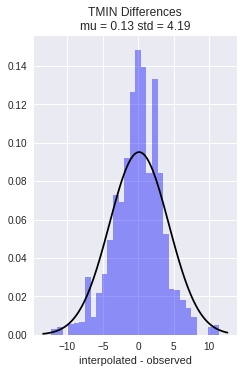

In [0]:
#TMAX difs plot for April to October
from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMAX_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMAX_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMAX Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


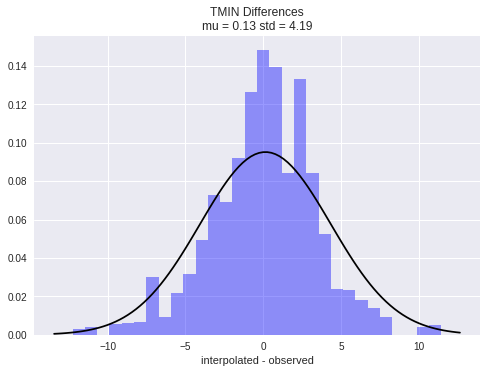

In [0]:
#TMIN difs plot for April to October
from scipy.stats import norm

mu, std = norm.fit(TMIN_difs)

plt.hist(TMIN_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMAX_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMIN Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))
plt.show()

In [0]:
#change sample year so it encompasses larger portions of 2017 (April to October)

#Function that finds differences between observed temperatures and interpolated temperatures.
#Remove 7 DAYS OF DATA 
#Plot the differences in a histogram to get a sense of the distribution

#import necessary packages
import pandas as pd
import numpy as np
import copy 
import random

#empty lists to collect differences
TMIN_difs_total = []
TMAX_difs_total = []

#collect random days to see what was selected
random_days = []

#set number of interations with range
for i in range(1000):
  
  #read in observed TMIN and TMAX data. Sample only 2017.
  temp = pd.read_csv('tmax_tmin.csv', header = 0, index_col= 0)
  temp.index = pd.to_datetime(temp.index)
  temp_sample = copy.deepcopy(temp.loc['2017-04-01':'2017-10-31'])
  
  #generate random days. Set to 82 because selecting 10 days and don't want overflow. No 92nd day in range.
  for x in range(1):
    random_day = random.randint(1,85)
  
  random_days.append(random_day)
  
  #set 28 days in a row to nan to simulate missing data
  temp_sample.iloc[random_day:random_day + 7] = np.nan

  #linearly interpolate between missing days
  temp_sample_interpolated = temp_sample.interpolate()

  missing = temp_sample.iloc[random_day:random_day+7]
  interpolated = temp_sample_interpolated.iloc[random_day:random_day+7]
  original = temp.loc[temp_sample.iloc[random_day:random_day+7].index]
  
  #difference defined as interpolated - original. Negative means underpredicted. Positive means overpredicted.
  aggregate = pd.concat([missing, interpolated, original], axis = 1)
  aggregate.columns = ['TMAX_obs','TMIN_obs','TMAX_inter','TMIN_inter','TMAX_original','TMIN_original']
  aggregate['TMAX_difference'] = aggregate['TMAX_inter'] - aggregate['TMAX_original']
  aggregate['TMIN_difference'] = aggregate['TMIN_inter'] - aggregate['TMIN_original']
  
  TMAX_difs_list = aggregate.TMAX_difference.tolist()
  
  TMIN_difs_list = aggregate.TMIN_difference.tolist()
  
  TMAX_difs_total.append(TMAX_difs_list)
  TMIN_difs_total.append(TMIN_difs_list)
  
  if (i % 100) == 0:
    print('in progress...')

#result is a list of lists. convert to array to flatten and then back to list for plotting.
TMAX_difs = np.asarray(TMAX_difs_total)
TMAX_difs = TMAX_difs.flatten()
TMAX_difs = TMAX_difs.tolist()

TMIN_difs = np.asarray(TMIN_difs_total)
TMIN_difs = TMIN_difs.flatten()
TMIN_difs = TMIN_difs.tolist()

in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...
in progress...


Text(0.5, 1.0, 'TMAX Differences\nmu = -0.18 std = 5.04')

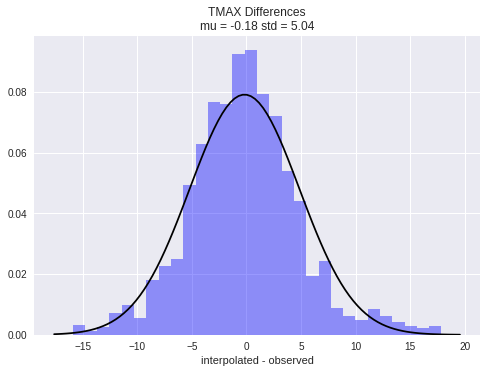

In [0]:
#TMAX difs plot for April to October
from scipy.stats import norm

mu, std = norm.fit(TMAX_difs)

plt.hist(TMAX_difs, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(TMAX_difs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('interpolated - observed')
plt.title('TMAX Differences\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)))


In [0]:
temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp = temp.loc['1981-01-01':'2017-12-31']

missingdata = temp[temp.isnull().any(axis=1)]
len(missingdata.index)

506

In [0]:
#counts the number of ones in a row
#use flag and value of t to determine what should be done

data = {'col_1': [0, 1, 1, -3, 7, 1, 3]}
data = pd.DataFrame.from_dict(data)

count = 0
flag = False

for t in data.col_1:
  if flag == False and t != 1:
    continue
  
  elif flag == False and t == 1:
    count = count + 1
    flag = True
    
  elif flag == True and t == 1:
    count = count + 1
    
  elif flag == True and t != 1:
    flag = False
    
    print(count)
      
    count = 0

2
1


In [0]:
#counts the number of nans in a row
#use flag and value of t to determine what should be done. flag tells me what the previous value was. 
#flag = True means previous was nan, flag = False means previous was number


#NEED TO FIGURE OUT HOW TO GET THE START AND END INDEX TO INTERPOLATE BETWEEN POINTS
data = {'col_1': [0, np.nan, np.nan, -3, 7, np.nan, 3]}
data = pd.DataFrame.from_dict(data)
data['col_2'] = pd.date_range(start = '2018-01-01', end = '2018-01-7')
data = data.set_index('col_2')

count = 0
flag = False

for t in data.col_1:
  #encounter number after encountering number
  if flag == False and ~np.isnan(t):
    continue
  
  #encounter nan after encountering number
  elif flag == False and np.isnan(t):
    count = count + 1 
    flag = True
  
  #encounter nan after encountering nan
  elif flag == True and np.isnan(t):
    
    count = count + 1
  
  #encounter number after encountering nan
  elif flag == True and ~np.isnan(t):
   
    flag = False
    
    print(count)
      
    count = 0
    

2
1


In [0]:
#Figure out which index to pick out for interpolation and how to update the existing dataframe with interpolated data

data = {'col_1': [0, np.nan, np.nan, -3, 7, np.nan, 3, 5, 6, 7, 8, 8]}
data = pd.DataFrame.from_dict(data)
data['col_2'] = pd.date_range(start = '2018-01-01', end = '2018-01-12')
data = data.set_index('col_2')

data_interpolate = data[0:4].interpolate()

data_interpolate

data.update(data_interpolate) #dataframe that needs to be updated(updated data points)

data


#now use enumerate instead of manually putting in the index numbers
for index, t in enumerate(data.col_1, start = 0):
  print(data.index[index])


  

In [0]:
#Find the number of nans in a row in actual data from Jan 01 2016 to Dec 31 2017
temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp_sample = copy.deepcopy(temp.loc['2016-01-01':'2017-12-31'])

count = 0
flag = False

for t in temp_sample.TMAX_obs:
  
  if flag == False and ~np.isnan(t):
    continue
    
  elif flag == False and np.isnan(t):
    flag = True
    count = count + 1
    
  elif flag == True and np.isnan(t):
    count = count + 1
    
  elif flag == True and ~np.isnan(t):
    flag = False
    
    print(count)
    
    count = 0
   

1
36
1
1
1
1
1
2
1
1
1
1


In [0]:
#Find the number of nans in a row in actual data from Jan 01 1981 to Dec 31 2017. Store as a list to plot later.
temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp_sample = copy.deepcopy(temp.loc['1981-01-01':'2017-12-31'])

count = 0
list_count = []
flag = False

for t in temp_sample.TMAX_obs:
  
  if flag == False and ~np.isnan(t):
    continue
    
  elif flag == False and np.isnan(t):
    flag = True
    count = count + 1
    
  elif flag == True and np.isnan(t):
    count = count + 1
    
  elif flag == True and ~np.isnan(t):
    flag = False
    
    list_count.append(count)
    
    count = 0

Text(0, 0.5, 'Frequency')

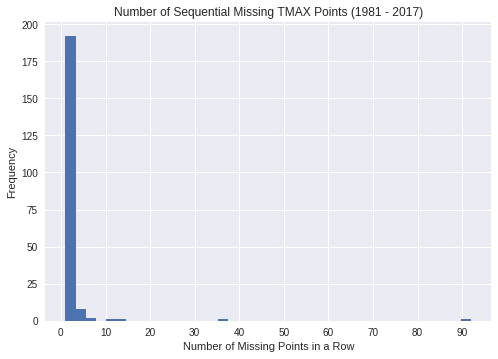

In [0]:
#Visualize how many occurences of missing data points in a row there are for TMAX in Jan 01 1981 to Dec 31 2017.

from pylab import xticks

plt.hist(list_count,bins = 40)
xticks(range(0,100,10))
plt.title('Number of Sequential Missing TMAX Points (1981 - 2017)')
plt.xlabel('Number of Missing Points in a Row')
plt.ylabel('Frequency')

In [0]:
#Interpolate the nans from Jan 01 2016 to Dec 31 2017 without regard the length of missing data.

temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp_sample = copy.deepcopy(temp.loc['2016-01-01':'2017-12-31'])

temp_TMAX = copy.deepcopy(temp_sample[['TMAX_obs']])

count = 0
flag = False

for index, t in enumerate(temp_TMAX.TMAX_obs):
  
  if flag == False and ~np.isnan(t):
    continue
    
  elif flag == False and np.isnan(t):
    flag = True
    start_index = temp_TMAX.index[index-1] #find index of point right before first nan
    count = count + 1
    
  elif flag == True and np.isnan(t):
    count = count + 1
    
  elif flag == True and ~np.isnan(t):
    flag = False
    end_index = temp_TMAX.index[index] #finds the index of numerical value following nan
    
    interpolated = temp_TMAX[start_index:end_index].interpolate() #interpolates between known points
    
    temp_TMAX.update(interpolated) #update the uninterpolated data with the newly interpolated
   
    #print(start_index, end_index, count)
    
    count = 0



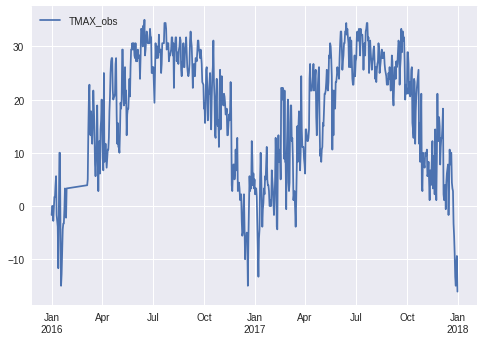

In [0]:
#quickly plot the result of interpolation to make sure it works. large flat section reaffirms that linear interpolation not appropriate for certain
#lengths of nans
temp_TMAX.plot()

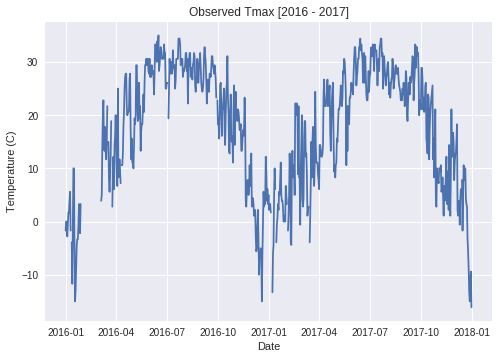

In [0]:
#plot uninterpolated data to compare with above plot

temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp_sample = copy.deepcopy(temp.loc['2016-01-01':'2017-12-31'])

temp_TMAX = copy.deepcopy(temp_sample[['TMAX_obs']])

temp_TMAX.index = pd.to_datetime(temp_TMAX.index)

x = temp_TMAX.index
y = temp_sample.TMAX_obs

plt.plot(x,y)

plt.title('Observed Tmax [2016 - 2017]')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [0]:
#now we need to add cases for certain lengths of nans. 
#rule 1: Linear interpolation only fit if missing 7 or less days
#rule 2: Remove year if missing more than 7 days


temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = copy.deepcopy(temp.loc['1981-01-01':'2017-12-31'])

temp_TMAX = copy.deepcopy(temp_sample[['TMAX_obs']])

count = 0
flag = False
bad_years_TMAX = []

for index, t in enumerate(temp_TMAX.TMAX_obs):
  
  if flag == False and ~np.isnan(t):
    continue
    
  elif flag == False and np.isnan(t):
    flag = True
    start_index = temp_TMAX.index[index-1] #find index of point right before first nan
    count = count + 1
    
  elif flag == True and np.isnan(t):
    count = count + 1
    
  elif flag == True and ~np.isnan(t):
    flag = False
    end_index = temp_TMAX.index[index] #finds the index of numerical value following nan
    
    if count <= 7:
      interpolated = temp_TMAX[start_index:end_index].interpolate() #interpolates between known points
      temp_TMAX.update(interpolated) #update the uninterpolated data with the newly interpolated data
      
    elif count > 7:
      if end_index.year not in bad_years_TMAX:
        bad_years_TMAX.append(end_index.year)
        
        if start_index.year not in bad_years_TMAX: #in case missing data stretches between years
          bad_years_TMAX.append(start_index.year)
        
    count = 0

#add a years column
temp_TMAX['year'] = temp_TMAX.index.year  

#drop the rows in bad years
for b in bad_years_TMAX:
  temp_TMAX = temp_TMAX[temp_TMAX.index.year != b]

#drop the year column
temp_TMAX = temp_TMAX.drop(columns = ['year'])

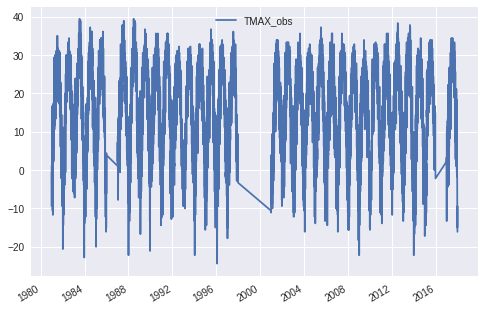

In [67]:
#looks like interpolating across entire year?

temp_TMAX.plot()

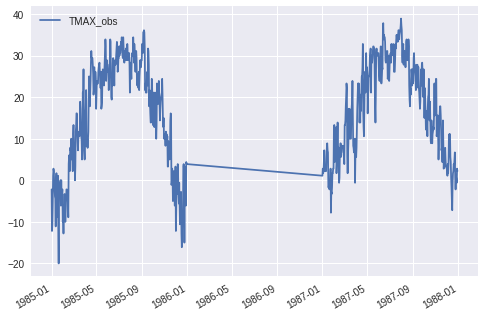

In [8]:
#zoom in on one of the straight portions
temp_TMAX.loc['1985-01-01':'1987-12-31'].plot()

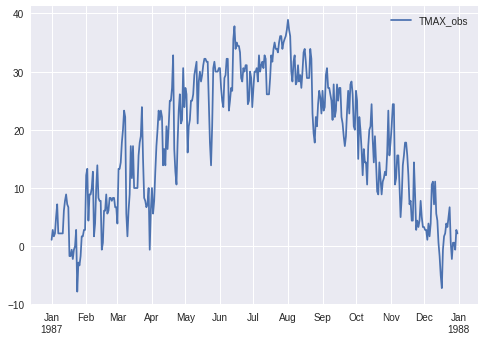

In [18]:
temp_TMAX.loc['1987-01-01':'1987-12-31'].plot()

In [0]:
#This gives me 'TypeError: Empty 'DataFrame': no numeric data to plot' so why is it plotted in above data?
temp_TMAX.loc['1986-05-01':'1986-09-01'].plot()

In [28]:
#there should be no data points for these years in resulting temp_TMAX
bad_years_TMAX

[1986, 1999, 1998, 2000, 2016]

In [0]:
#No data in this year but plot is picking something up?
temp_TMAX.loc['1986-01-01':'1986-12-31'].plot()

In [0]:
#Use the above function but do it for TMIN values now 

temp = pd.read_csv('tmax_tmin.csv', index_col = 0, header = 0)

temp.index = pd.to_datetime(temp.index)

temp_sample = copy.deepcopy(temp.loc['1981-01-01':'2017-12-31'])

temp_TMIN = copy.deepcopy(temp_sample[['TMIN_obs']])

count = 0
flag = False
bad_years_TMIN = []

for index, t in enumerate(temp_TMIN.TMIN_obs):
  
  if flag == False and ~np.isnan(t):
    continue
    
  elif flag == False and np.isnan(t):
    flag = True
    start_index = temp_TMIN.index[index-1] #find index of point right before first nan
    count = count + 1
    
  elif flag == True and np.isnan(t):
    count = count + 1
    
  elif flag == True and ~np.isnan(t):
    flag = False
    end_index = temp_TMIN.index[index] #finds the index of numerical value following nan
    
    if count <= 7:
      interpolated = temp_TMIN[start_index:end_index].interpolate() #interpolates between known points
      temp_TMIN.update(interpolated) #update the uninterpolated data with the newly interpolated data
      
    elif count > 7:
      if end_index.year not in bad_years_TMIN:
        bad_years_TMIN.append(end_index.year)
        
        if start_index.year not in bad_years: #in case missing data stretches between years
          bad_years_TMIN.append(start_index.year)
        
    count = 0

#add a years column
temp_TMIN['year'] = temp_TMIN.index.year  

#drop the rows in bad years
for b in bad_years_TMIN:
  temp_TMIN = temp_TMIN[temp_TMIN.index.year != b]

#drop the year column
temp_TMIN = temp_TMIN.drop(columns = ['year'])

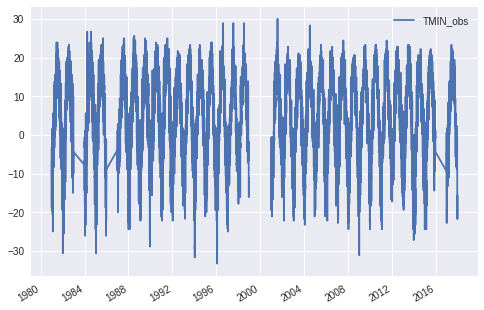

In [87]:
temp_TMIN.plot()

In [85]:
temp_TMIN.index.values

array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ...,
       '2017-12-29T00:00:00.000000000', '2017-12-30T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [0]:
#combine TMAX and TMIN.

temp_TMAX['TMIN_obs'] = temp_TMIN
temp_data = temp_TMAX

In [98]:
bad_years_TMAX


[1986, 1999, 1998, 2000, 2016]

In [99]:
bad_years_TMIN

[1983, 1986, 1999, 2000, 2016]

In [0]:
bad_years = bad_years_TMAX + bad_years_TMIN
bad_years = set(bad_years) #keep only unique values and put in numerical order
bad_years = list(bad_years) #back to list

In [0]:
#remove any bad years that were not in common between TMIN and TMAX
for b in bad_years:
  temp_data = temp_data[temp_data.index.year != b]

In [0]:
#moment of truth: is there any missing data? Nope!
missingdata = temp_data[temp_data.isnull().any(axis=1)]
len(missingdata)

#save as csv
temp_data.to_csv('tmin_tmax_cleaned.csv')

In [113]:
#now we need to calcuate GDD and KDD. start by bounding TMAX and TMIN as done in study.

#make new columns for bounded values
temp_data['TMAX_bound'] = temp_data['TMAX_obs']
temp_data['TMIN_bound'] = temp_data['TMIN_obs']

temp_data.loc[temp_data.TMAX_bound >= 29, 'TMAX_bound'] = 29
temp_data.loc[temp_data.TMAX_bound <= 9, 'TMAX_bound'] = 9

temp_data.loc[temp_data.TMIN_bound >= 29, 'TMIN_bound']  = 29
temp_data.loc[temp_data.TMIN_bound <= 9, 'TMIN_bound'] = 9

#make new columns for GDD
temp_data['GDD'] = (((temp_data.TMIN_bound) + (temp_data.TMAX_bound))/2) - 9

#make new column for KDD. np.where(condition, value if true, value if false)
temp_data['KDD'] = np.where(temp_data.TMAX_obs > 29, temp_data.TMAX_obs - 29, 0)

#check out df
temp_data.loc['1981-08-01':'1981-08-14']

,TMAX_obs,TMIN_obs,TMAX_bound,TMIN_bound,GDD,KDD
1981-08-01,29.4,15.6,29.0,15.6,13.30,0.4
1981-08-02,27.2,20.0,27.2,20.0,14.60,0.0
1981-08-03,28.3,18.9,28.3,18.9,14.60,0.0
1981-08-04,31.7,19.4,29.0,19.4,15.20,2.7
1981-08-05,30.6,21.1,29.0,21.1,16.05,1.6
1981-08-06,30.0,18.3,29.0,18.3,14.65,1.0
1981-08-07,28.3,16.7,28.3,16.7,13.50,0.0
1981-08-08,26.7,16.1,26.7,16.1,12.40,0.0
1981-08-09,28.3,16.7,28.3,16.7,13.50,0.0
1981-08-10,26.1,17.2,26.1,17.2,12.65,0.0


In [0]:
temp_data.to_csv('GDD_KDD_Cleaned.csv')